<a href="https://colab.research.google.com/github/GaryM02/applied_predictive_analytics/blob/main/vit_cnn_downstream_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/PredictiveAnalyticsProject')

Mounted at /content/drive


# Define Training Functions

In [13]:
# Model Preparation
def prepare_model(model_name, num_classes, pretrained=True):
    """
    Loads a pre-trained model, modifies the classification head for the specified number of classes.
    """
    model = timm.create_model(model_name, pretrained=pretrained)
    if 'vit' in model_name:  # Vision Transformer
        model.head = nn.Linear(model.head.in_features, num_classes)
    elif 'efficientnetv2' in model_name:  # EfficientNetV2
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    return model

# Freezing initial layers
def freeze_initial_layers(model, num_layers_to_freeze):
    frozen = 0
    for name, module in model.named_children():
        if frozen < num_layers_to_freeze:
            for param in module.parameters():
                param.requires_grad = False
            frozen += 1
        else:
            break

# Data Loading
def load_data(batch_size=512):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = datasets.ImageFolder(root='data/train', transform=train_transform)
    val_dataset = datasets.ImageFolder(root='data/validation', transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=16, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=16, pin_memory=True)
    return train_loader, val_loader

# Save model state for resume training
def save_checkpoint(model, optimizer, epoch, best_f1, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_f1': best_f1
    }
    torch.save(checkpoint, filepath)

# Load model state for resume training
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_f1 = checkpoint['best_f1']
    return model, optimizer, epoch, best_f1

# Train one epoch
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_predictions = [], []

    progress = tqdm(loader, desc="Training", leave=False)
    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return running_loss / len(loader), f1

# Validate the model
def validate_model(model, loader, criterion, device):
    model.eval()
    running_loss, all_labels, all_predictions = 0.0, [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return running_loss / len(loader), f1, all_labels, all_predictions

# Plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    for key, values in metrics.items():
        plt.plot(values, label=key)
    plt.legend()
    plt.show()

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, resume_path=None):
    num_epochs = 25
    early_stopping_patience = 5
    early_stopping_counter = 0
    best_f1 = 0.0
    metrics = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}
    start_epoch = 0

    # Resume training if a checkpoint is provided
    if resume_path:
        model, optimizer, start_epoch, best_f1 = load_checkpoint(resume_path, model, optimizer)
        print(f"Resumed training from epoch {start_epoch} with best F1: {best_f1:.4f}, lr: {optimizer.param_groups[0]['lr']}")

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss, val_f1, val_labels, val_preds = validate_model(model, val_loader, criterion, device)

        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["train_f1"].append(train_f1)
        metrics["val_f1"].append(val_f1)

        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

        scheduler.step()

        # Save the best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, optimizer, epoch, best_f1, "best_model.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    plot_metrics(metrics)

# Evaluate the model on a test dataset
def evaluate_test_dataset(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Metrics Calculation
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions, target_names=test_loader.dataset.classes)

    # Print Metrics
    print(f"Weighted F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(class_report)

    # Confusion Matrix Visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

## Create profiler to track performance and bottlenecks

# Main

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Prepare model and optimizer
model = prepare_model('vit_base_patch16_224_in21k', num_classes=10)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

In [10]:
freeze_initial_layers(model, 5)
train_loader, val_loader = load_data(batch_size=128)

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10, mode='triangular')
scaler = torch.amp.GradScaler('cuda')

<ipython-input-9-55b3b945ea2b>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Resumed training from epoch 12 with best F1: 0.7674
Epoch 13/25


Train Loss: 1.0271, Train F1: 0.7704
Val Loss: 1.0497, Val F1: 0.7661
Epoch 14/25


Train Loss: 1.0232, Train F1: 0.7726
Val Loss: 1.0472, Val F1: 0.7663
Epoch 15/25


Train Loss: 1.0213, Train F1: 0.7690
Val Loss: 1.0514, Val F1: 0.7631
Epoch 16/25


Train Loss: 1.0274, Train F1: 0.7693
Val Loss: 1.0491, Val F1: 0.7711
Epoch 17/25


Train Loss: 1.0264, Train F1: 0.7694
Val Loss: 1.0398, Val F1: 0.7659
Epoch 18/25


Train Loss: 1.0272, Train F1: 0.7681
Val Loss: 1.0579, Val F1: 0.7565
Epoch 19/25


Train Loss: 1.0296, Train F1: 0.7639
Val Loss: 1.0280, Val F1: 0.7715
Epoch 20/25


Train Loss: 1.0349, Train F1: 0.7669
Val Loss: 1.0446, Val F1: 0.7628
Epoch 21/25


Train Loss: 1.0492, Train F1: 0.7598
Val Loss: 1.0645, Val F1: 0.7630
Epoch 22/25


Train Loss: 1.0524, Train F1: 0.7558
Val Loss: 1.1218, Val F1: 0.7224
Epoch 23/25


Train Loss: 1.0500, Train F1: 0.7601
Val Loss: 1.0667, Val F1: 0.7545
Epoch 24/25


Train Loss: 1.0434, Train F1: 0.7607
Val Loss: 1.0421, Val F1: 0.7618
Early stopping triggered.


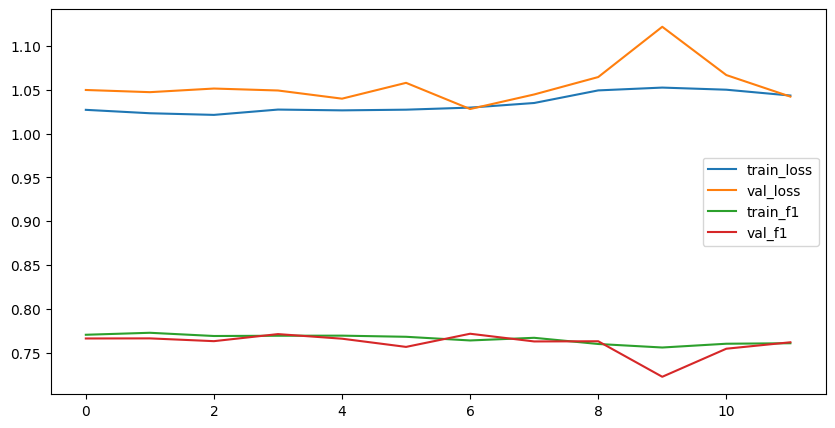

In [11]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, resume_path="best_model.pth")

In [14]:
# evaluate with test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_dataset = datasets.ImageFolder(root='data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=8, pin_memory=True)


In [16]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-16-2c924bc05b6e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


<All keys matched successfully>

Weighted F1 Score: 0.7703

Classification Report:

                               precision    recall  f1-score   support

            Atopic Dermatitis       0.59      0.38      0.46       190
         Basal Cell Carcinoma       0.88      0.85      0.87       499
Benign Keratosis-like Lesions       0.70      0.69      0.70       313
                 Benign Tumor       0.77      0.68      0.72       279
                       Eczema       0.56      0.59      0.57       253
             Fungal Infection       0.62      0.50      0.55       257
             Melanocytic Nevi       0.93      0.94      0.93      1197
                     Melanoma       0.93      0.96      0.94       473
                    Psoriasis       0.53      0.52      0.52       310
             Viral Infections       0.53      0.75      0.62       316

                     accuracy                           0.77      4087
                    macro avg       0.70      0.69      0.69      4087
                 weighte

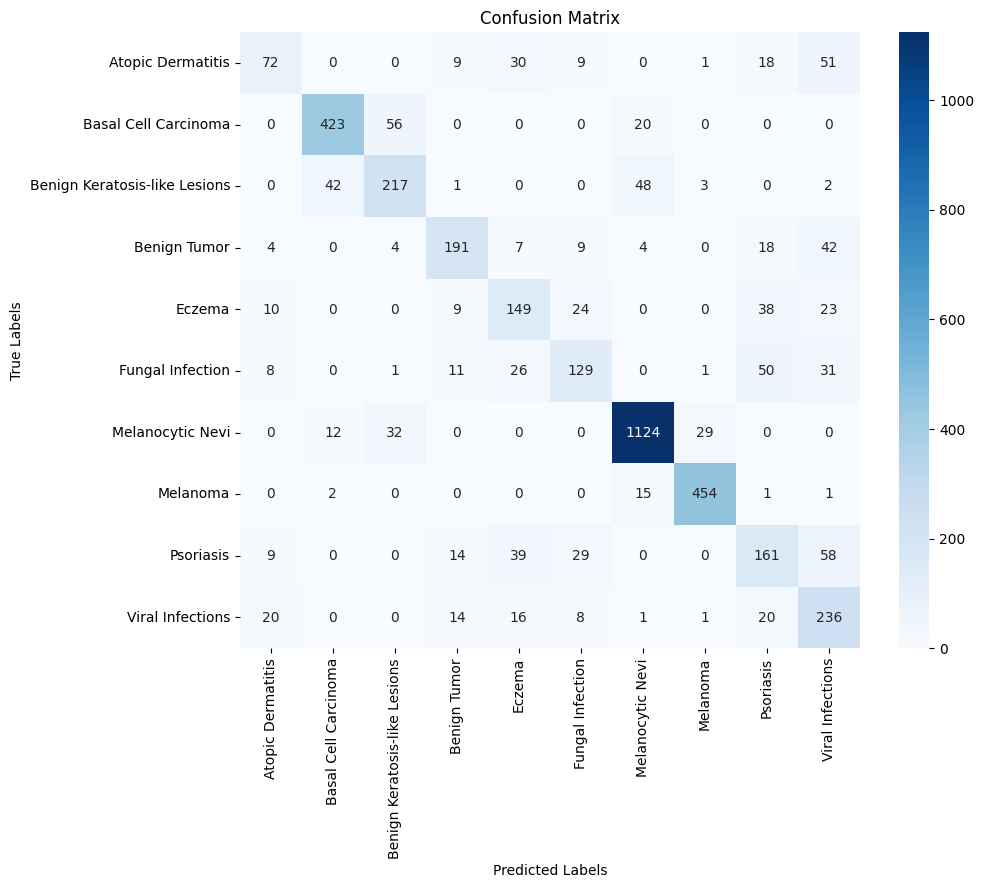

In [17]:
evaluate_test_dataset(model, test_loader, device)

# Profiling fr optimal performance

In [ ]:
# clear ram
import gc
gc.collect()
torch.cuda.empty_cache()

# clear system ram
import psutil
psutil.virtual_memory().available


# Key Features Used
Visualization with Matplotlib: Plots training/validation loss and F1 scores dynamically.

Gradient Monitoring: Part of mixed precision scaling (scaler.update()).

Memory Usage Profiling: Integrated into adjust_batch_size.

Dynamic Batch Size Adjustment: Automatically adjusts to prevent OOM errors.

Mixed Precision Training: Uses torch.cuda.amp for speed and memory efficiency.

Efficient Checkpointing: Saves the model only when validation F1 improves.

Distributed Training: Supports multi-GPU with nn.DataParallel.

Hyperparameter Tuning: Scheduler controls learning rate dynamically.

Dropout Regularization: Implicitly part of pre-trained models.

Cyclic Learning Rate Scheduling: Integrated using CyclicLR.

Early Stopping with Multiple Metrics: Stops training when metrics stop improving.

Warmup Phases for Learning Rates: Achieved via cyclic scheduler.

Confusion Matrix and Classification Report: Provides detailed evaluation metrics.

Per-Class Metrics: Delivered via classification report.

Robust Test Evaluation: Final test set evaluation using the best model.
Progress Bars: Added via tqdm.